In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import math
from tqdm import trange
import os
from PIL import Image
import torchvision

# Define transformations for training data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Define transformations for safety set (including augmentation)
safety_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST('./data', train=False, transform=transform)

# Split data into tensors
X_train, Y_train = next(iter(torch.utils.data.DataLoader(
    train_dataset, batch_size=len(train_dataset))))
X_test, Y_test = next(iter(torch.utils.data.DataLoader(
    test_dataset, batch_size=len(test_dataset))))


In [2]:
# Define the quantized convolutional layer
class QConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(QConv2d, self).__init__()
        self.kernel_size = (kernel_size, kernel_size) if isinstance(
            kernel_size, int) else tuple(kernel_size)
        scale = 1 / math.sqrt(in_channels * math.prod(self.kernel_size))
        self.weight = nn.Parameter(torch.empty(
            out_channels, in_channels, *self.kernel_size).uniform_(-scale, scale))
        self.e = nn.Parameter(torch.full((out_channels, 1, 1, 1), -8.))
        self.b = nn.Parameter(torch.full((out_channels, 1, 1, 1), 32.))  # Start with 32 bits

    def qbits(self):
        return self.b.relu().sum() * self.weight[0].numel()

    def qweight(self):
        b_rel = self.b.relu()
        min_val = torch.where(b_rel > 0, -2 ** (b_rel - 1), torch.zeros_like(b_rel))
        max_val = torch.where(b_rel > 0, 2 ** (b_rel - 1) - 1, torch.zeros_like(b_rel))
        scaled_weight = 2 ** -self.e * self.weight
        qweight = torch.max(torch.min(scaled_weight, max_val), min_val)
        return qweight

    def forward(self, x):
        qw = self.qweight()
        w = (qw.round() - qw).detach() + qw  # Straight-through estimator
        return nn.functional.conv2d(x, 2 ** self.e * w)


In [3]:
# Define the CNN model using quantized convolutional layers
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.features = nn.Sequential(
            QConv2d(1, 32, 5), nn.ReLU(),
            QConv2d(32, 32, 5), nn.ReLU(),
            nn.BatchNorm2d(32, affine=False, track_running_stats=False),
            nn.MaxPool2d(2),
            QConv2d(32, 64, 3), nn.ReLU(),
            QConv2d(64, 64, 3), nn.ReLU(),
            nn.BatchNorm2d(64, affine=False, track_running_stats=False),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(64 * 3 * 3, 10)  # Adjusted to 64 * 3 * 3

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.classifier(x)
        return x

    def qbits(self):
        return sum(l.qbits() for l in self.features if isinstance(l, QConv2d))


In [4]:
# Define the SafetySetDataset class
class SafetySetDataset(torch.utils.data.Dataset):
    def __init__(self, safety_set_path, transform=None):
        self.image_paths = []
        self.labels = []
        self.transform = transform
        for file in os.listdir(safety_set_path):
            if file.endswith('.png'):
                label_str = file.split('_label_')[-1].split('.png')[0]
                label = int(label_str)
                image_path = os.path.join(safety_set_path, file)
                self.image_paths.append(image_path)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
        else:
            image = transform(image)  # Default transform
        label = self.labels[idx]
        return image, label


In [5]:
# Instantiate the model and define optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model().to(device)
opt = optim.Adam(model.parameters())
weight_count = sum(p.numel() for p in model.parameters() if p.requires_grad)

# Load safety set
safety_set_path = "/home/mohammad/safety_set_images_d"  # Update this path if necessary
safety_dataset = SafetySetDataset(safety_set_path, transform=safety_transform)


In [6]:
# Define training step function with increased compression weight
def train_step():
    model.train()
    opt.zero_grad()
    # Main training batch
    samples = torch.randint(0, X_train.shape[0], (512,))
    outputs = model(X_train[samples].to(device))
    loss = nn.functional.cross_entropy(outputs, Y_train[samples].to(device))
    Q = model.qbits() / weight_count
    
    # **Increased compression regularization weight from 0.05 to 0.1**
    compression_weight = 0.1  # Adjusted from 0.05 to 0.1
    loss = loss + compression_weight * Q  # Hyperparameter determines compression vs accuracy

    # Safety set penalty
    # Randomly sample from safety dataset with augmentation
    safety_indices = torch.randint(0, len(safety_dataset), (64,))
    safety_images_batch = []
    safety_labels_batch = []
    for idx in safety_indices:
        img, label = safety_dataset[idx]
        safety_images_batch.append(img)
        safety_labels_batch.append(label)
    safety_images_batch = torch.stack(safety_images_batch).to(device)
    safety_labels_batch = torch.tensor(safety_labels_batch).to(device)
    safety_outputs = model(safety_images_batch)
    safety_loss = nn.functional.cross_entropy(safety_outputs, safety_labels_batch)
    
    # **Adjusted safety loss weight to balance compression and safety**
    safety_weight = 0.05  # Reduced from 0.1 to 0.05
    loss = loss + safety_weight * safety_loss

    loss.backward()
    opt.step()
    return loss.item(), Q.item(), safety_loss.item()


In [7]:
# Functions to get test and safety accuracies
def get_test_acc():
    model.eval()
    with torch.no_grad():
        outputs = model(X_test.to(device))
        pred = outputs.argmax(dim=1)
        return (pred == Y_test.to(device)).float().mean().item() * 100

# Safety set without augmentations for evaluation
safety_dataset_eval = SafetySetDataset(safety_set_path, transform=transform)
safety_loader_eval = torch.utils.data.DataLoader(safety_dataset_eval, batch_size=64, shuffle=False)

def get_safety_acc():
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in safety_loader_eval:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            pred = outputs.argmax(dim=1)    
            correct += (pred == labels).sum().item()
            total += labels.size(0)
    return (correct / total) * 100


In [8]:
# Functions to check and restore zero-bit kernels
def check_zero_bit_kernels():
    for layer in model.features:
        if isinstance(layer, QConv2d):
            if (layer.b.view(-1) <= 0).any():
                return True
    return False

def restore_zero_bit_kernels(restore_fraction=0.1):  # Reduced restore_fraction from 0.2 to 0.1
    for layer in model.features:
        if isinstance(layer, QConv2d):
            b_flat = layer.b.view(-1)
            zero_bit_indices = (b_flat <= 0).nonzero(as_tuple=False).view(-1)
            num_restore = int(restore_fraction * len(zero_bit_indices))  # Restore a smaller fraction
            if num_restore > 0:
                restore_indices = zero_bit_indices[torch.randperm(len(zero_bit_indices))[:num_restore]]
                b_flat[restore_indices] = 2.0  # Restore bits to 2


loss:   2.06  bytes: 224730.3  acc: 99.24%  safety_loss: 0.08: 100%|██████████| 10000/10000 [21:31<00:00,  7.74it/s]


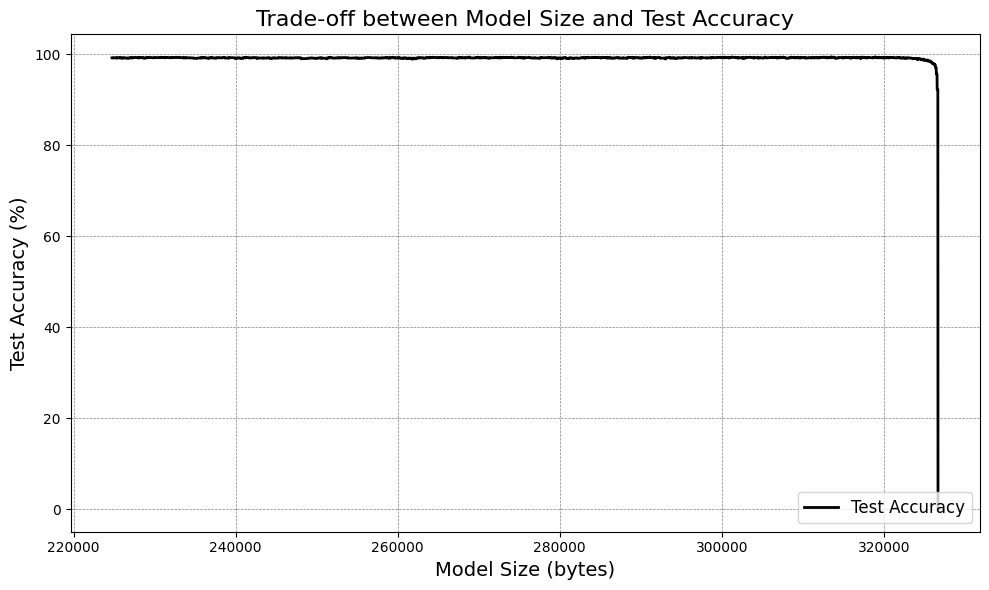

In [9]:
import matplotlib.pyplot as plt

# Variables for tracking
prev_safety_acc = None
# **Increased safety_acc_drop_threshold to allow more compression before restoring kernels**
safety_acc_drop_threshold = 15.0  # Increased from 10.0 to 15.0 percentage points
test_accs, bytes_used, safety_losses = [], [], []

# Initial safety accuracy
initial_safety_acc = get_safety_acc()
prev_safety_acc = initial_safety_acc

# Training loop
for i in (t := trange(10000)):
    loss, Q, safety_loss = train_step()
    model_bytes = Q / 8 * weight_count
    if i % 10 == 9:
        test_acc = get_test_acc()
        safety_acc = get_safety_acc()
        acc_drop = prev_safety_acc - safety_acc
        if acc_drop > safety_acc_drop_threshold:
            if check_zero_bit_kernels():
                restore_zero_bit_kernels(restore_fraction=0.1)  # Restore fewer kernels
        prev_safety_acc = safety_acc
    else:
        test_acc = test_accs[-1] if test_accs else 0.0
    test_accs.append(test_acc)
    bytes_used.append(model_bytes)
    safety_losses.append(safety_loss)
    t.set_description(f"loss: {loss:6.2f}  bytes: {model_bytes:.1f}  acc: {test_acc:5.2f}%  safety_loss: {safety_loss:.2f}")

# Plotting the Trade-off between Model Size and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(bytes_used, test_accs, color='black', linewidth=2, label='Test Accuracy')
plt.xlabel('Model Size (bytes)', fontsize=14, color='black')
plt.ylabel('Test Accuracy (%)', fontsize=14, color='black')
plt.title('Trade-off between Model Size and Test Accuracy', fontsize=16, color='black')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('size_vs_accuracy.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


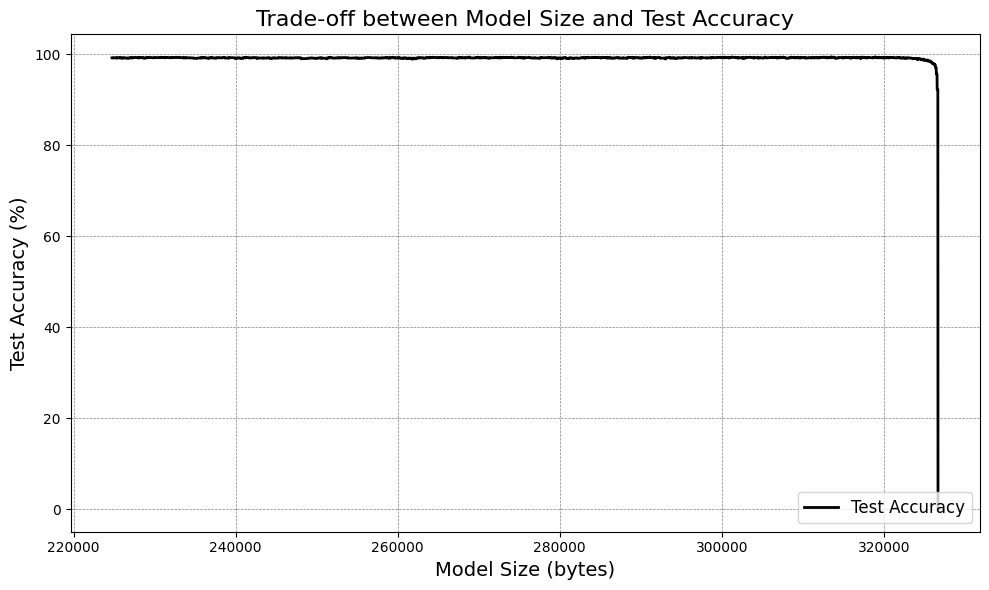

In [10]:
# Plotting the Trade-off between Model Size and Test Accuracy
plt.figure(figsize=(10, 6))
plt.plot(bytes_used, test_accs, color='black', linewidth=2, label='Test Accuracy')
plt.xlabel('Model Size (bytes)', fontsize=14, color='black')
plt.ylabel('Test Accuracy (%)', fontsize=14, color='black')
plt.title('Trade-off between Model Size and Test Accuracy', fontsize=16, color='black')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig('size_vs_accuracy.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()



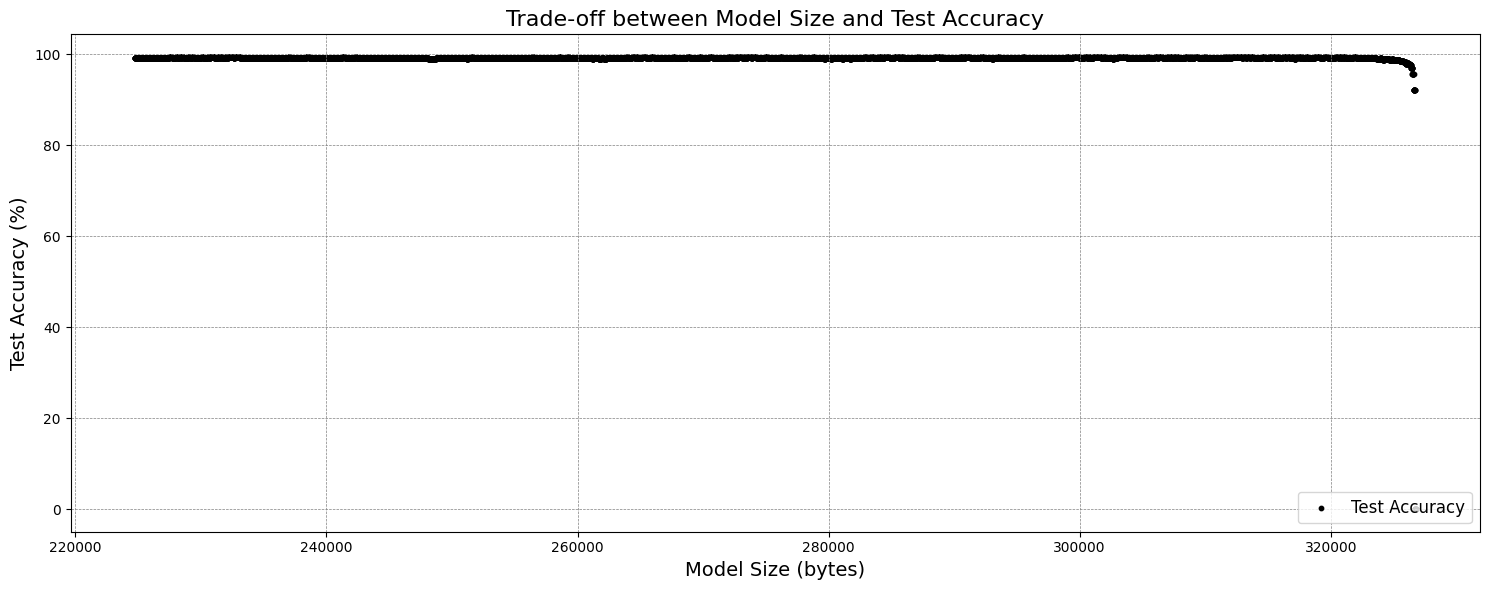

In [11]:
plt.figure(figsize=(15, 6))

# Plot only the points
plt.scatter(bytes_used, test_accs, color='black', s=10, label='Test Accuracy')

plt.xlabel('Model Size (bytes)', fontsize=14, color='black')
plt.ylabel('Test Accuracy (%)', fontsize=14, color='black')
plt.title('Trade-off between Model Size and Test Accuracy', fontsize=16, color='black')

# Customize grid for better readability
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)

plt.legend(loc='lower right', fontsize=12)
plt.tight_layout()

# Save the plot with high resolution
plt.savefig('size_vs_accuracy.png', dpi=300, bbox_inches='tight', facecolor='white')

# Display the plot
plt.show()

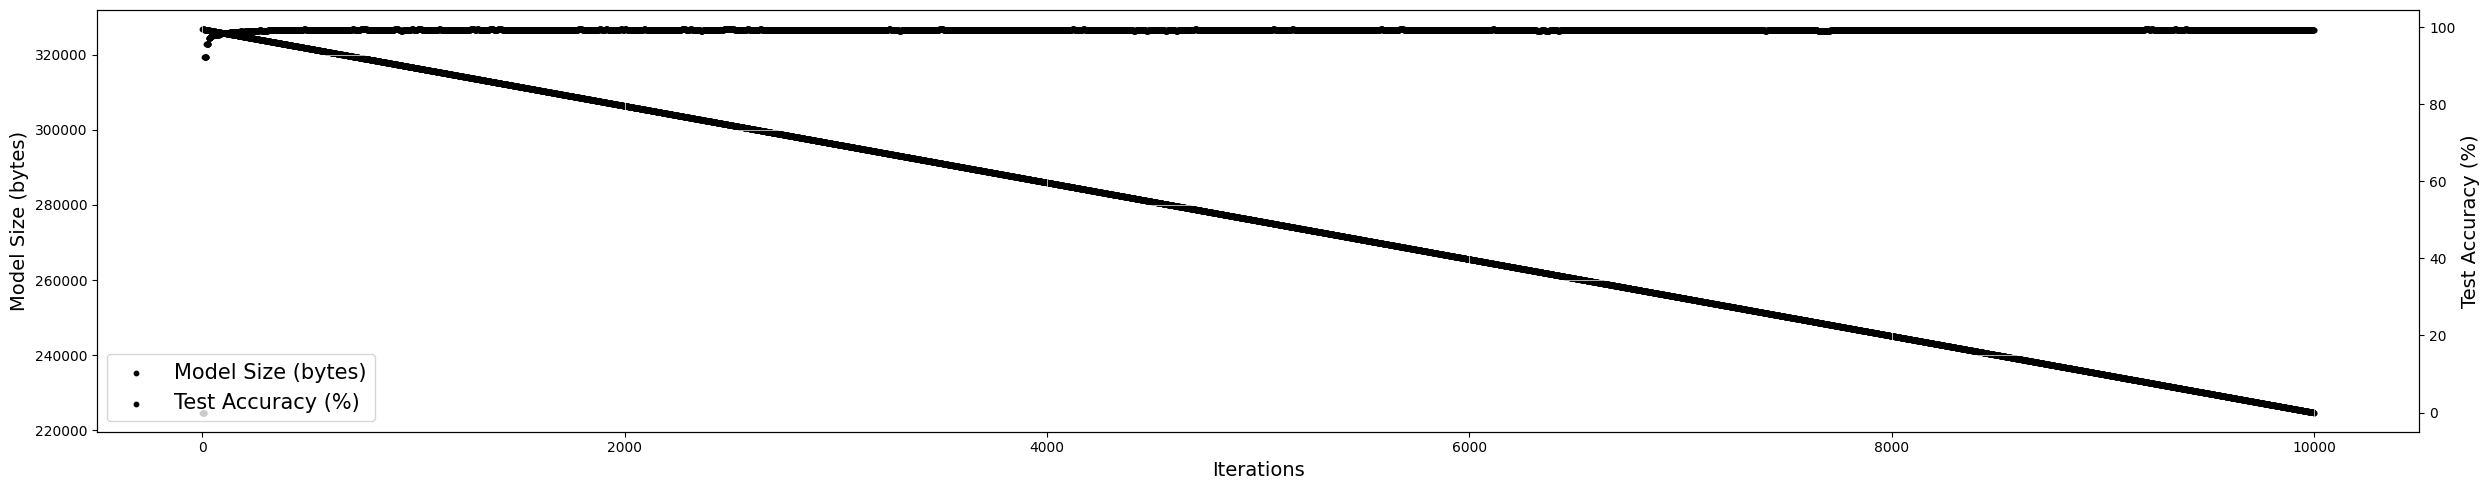

In [12]:
plt.figure(figsize=(25, 5))

# Create a secondary y-axis for Test Accuracy
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Model Size Decrease with exponential trend
ax1.scatter(range(len(bytes_used)), bytes_used, color='black', s=10, label='Model Size (bytes)')
ax1.set_xlabel('Iterations', fontsize=14, color='black')
ax1.set_ylabel('Model Size (bytes)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plot Test Accuracy Increase
ax2.scatter(range(len(test_accs)), test_accs, color='k', s=10, label='Test Accuracy (%)')
ax2.set_ylabel('Test Accuracy (%)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Grid
ax1.grid( color='white', linestyle='-', linewidth=0.5)

# Combine Legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
plt.legend(handles1 + handles2, labels1 + labels2, loc='lower left', fontsize=15)

# Adjust layout for better spacing
plt.tight_layout()

# Save and Show the Plot
# plt.savefig('size_vs_accuracy_iterations.png', dpi=300, bbox_inches='tight', facecolor='white', color='black')
plt.show()

In [13]:
import matplotlib.pyplot as plt

/tmp/ipykernel_15346/3467087123.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


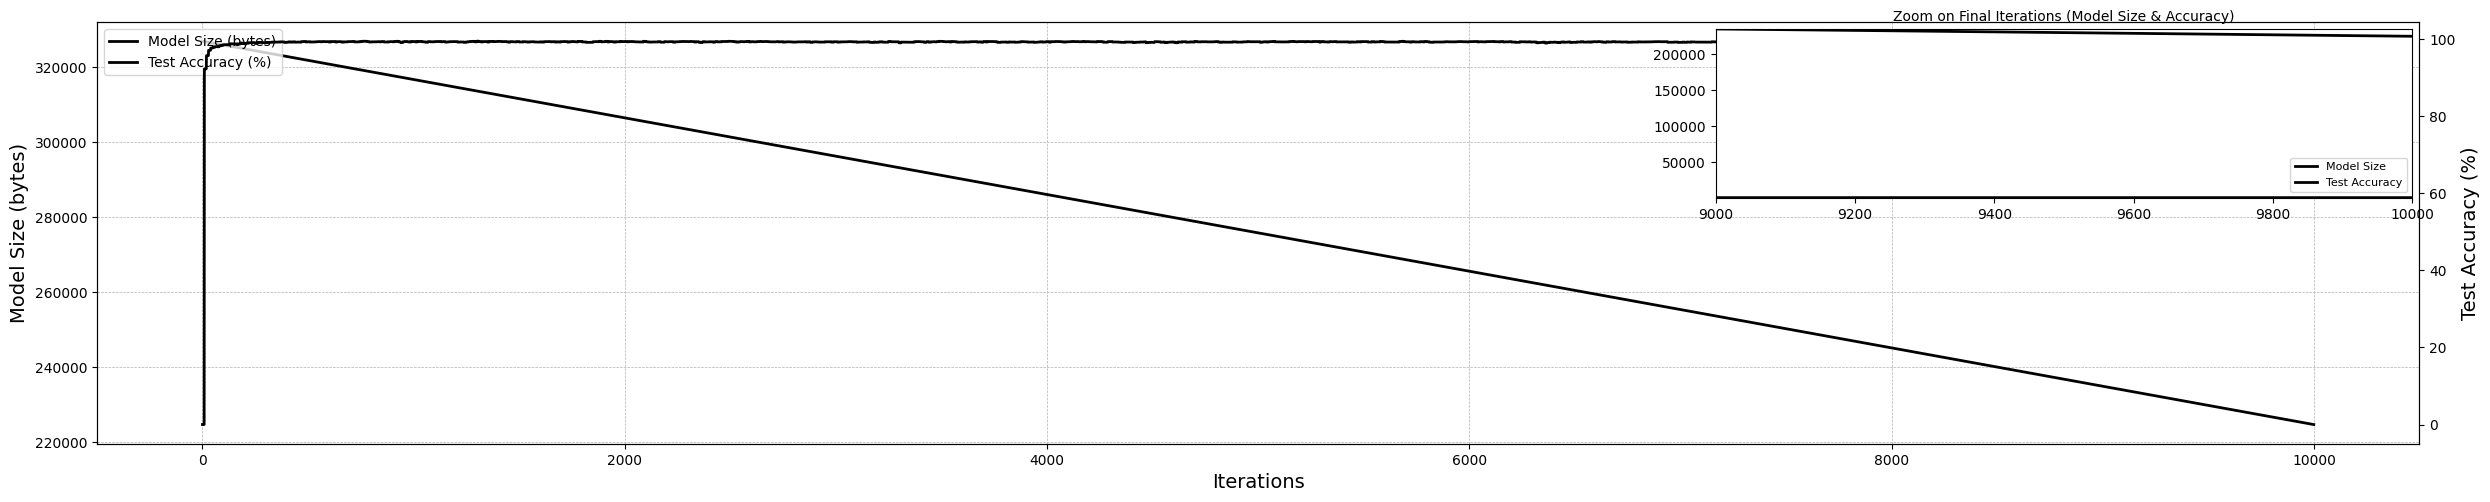

In [16]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(25, 5))

# Create the main plot with two y-axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Model Size Decrease in black
ax1.plot(range(len(bytes_used)), bytes_used, color='black', linewidth=2, label='Model Size (bytes)')
ax1.set_xlabel('Iterations', fontsize=14, color='black')
ax1.set_ylabel('Model Size (bytes)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plot Test Accuracy Increase in black
ax2.plot(range(len(test_accs)), test_accs, color='black', linewidth=2, label='Test Accuracy (%)')
ax2.set_ylabel('Test Accuracy (%)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Grid
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a zoomed inset for the last iterations, focusing on both model size and test accuracy
axins = inset_axes(ax1, width="30%", height="40%", loc="upper right")  # Adjust location and size

# Zoom in on the final iterations (e.g., last 10% of iterations)
zoom_start = int(len(bytes_used) * 0.9)  # Change this to adjust the zoom range
axins.plot(range(zoom_start, len(bytes_used)), bytes_used[zoom_start:], color='black', linewidth=2)
axins.plot(range(zoom_start, len(test_accs)), test_accs[zoom_start:], color='black', linewidth=2)

# Customize the inset appearance to show smaller fluctuations in both test accuracy and model size
axins.set_xlim(zoom_start, len(bytes_used))
axins.set_ylim(min(min(bytes_used[zoom_start:]), min(test_accs[zoom_start:])) - 1, 
               max(max(bytes_used[zoom_start:]), 99.5))  # Show full zoom range for both bytes and accuracy

axins.set_title("Zoom on Final Iterations (Model Size & Accuracy)", fontsize=10)

# Add a legend to the inset
axins.legend(['Model Size', 'Test Accuracy'], loc='lower right', fontsize=8)

# Combine Legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Save and Show the Plot
# plt.savefig('size_vs_accuracy_zoomed_black_fluctuations.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


/tmp/ipykernel_15346/1663227425.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


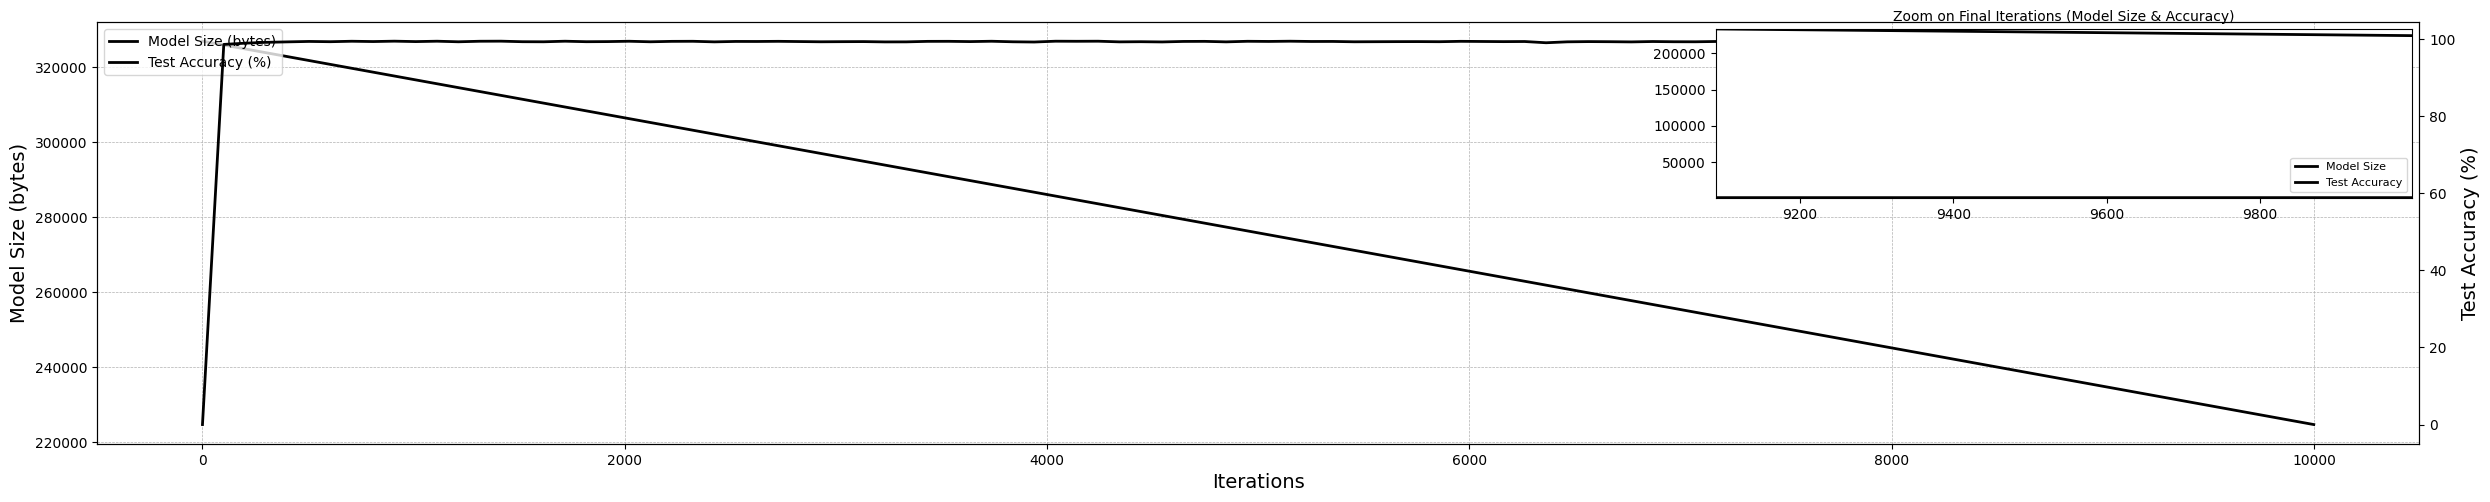

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Choose 100 evenly spaced points from the data
num_points = 100
indices = np.linspace(0, len(bytes_used) - 1, num_points, dtype=int)

# Create the figure and axis
plt.figure(figsize=(25, 5))

# Create the main plot with two y-axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Model Size Decrease (sampled data)
ax1.plot(indices, np.array(bytes_used)[indices], color='black', linewidth=2, label='Model Size (bytes)')
ax1.set_xlabel('Iterations', fontsize=14, color='black')
ax1.set_ylabel('Model Size (bytes)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plot Test Accuracy Increase (sampled data)
ax2.plot(indices, np.array(test_accs)[indices], color='black', linewidth=2, label='Test Accuracy (%)')
ax2.set_ylabel('Test Accuracy (%)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Grid
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a zoomed inset for the last iterations, focusing on both model size and test accuracy
axins = inset_axes(ax1, width="30%", height="40%", loc="upper right")  # Adjust location and size

# Zoom in on the final iterations (e.g., last 10% of iterations)
zoom_start = int(num_points * 0.9)  # Adjust to zoom on the last 10% of the sampled data
axins.plot(indices[zoom_start:], np.array(bytes_used)[indices[zoom_start:]], color='black', linewidth=2)
axins.plot(indices[zoom_start:], np.array(test_accs)[indices[zoom_start:]], color='black', linewidth=2)

# Customize the inset appearance to show smaller fluctuations in both test accuracy and model size
axins.set_xlim(indices[zoom_start], indices[-1])
axins.set_ylim(min(min(np.array(bytes_used)[indices[zoom_start:]]), min(np.array(test_accs)[indices[zoom_start:]])) - 1, 
               max(max(np.array(bytes_used)[indices[zoom_start:]]), 99.5))  # Show full zoom range for both bytes and accuracy

axins.set_title("Zoom on Final Iterations (Model Size & Accuracy)", fontsize=10)

# Add a legend to the inset
axins.legend(['Model Size', 'Test Accuracy'], loc='lower right', fontsize=8)

# Combine Legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles=handles1 + handles2, labels=labels1 + labels2, loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()

# Save and Show the Plot
# plt.savefig('size_vs_accuracy_sampled_zoomed.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [19]:
bytes_used

[326783.98975133896,
 326773.81044626236,
 326763.56830596924,
 326753.36805582047,
 326743.18875074387,
 326732.9675555229,
 326722.7882504463,
 326712.5670552254,
 326702.3458600044,
 326692.1246647835,
 326681.9453597069,
 326671.7451095581,
 326661.502969265,
 326651.3027191162,
 326641.1234140396,
 326630.90221881866,
 326620.6810235977,
 326610.5017185211,
 326600.2805233002,
 326590.1012182236,
 326579.8800230026,
 326569.6588277817,
 326559.4585776329,
 326549.25832748413,
 326539.05807733536,
 326528.81593704224,
 326518.61568689346,
 326508.43638181686,
 326498.25707674026,
 326487.99399137497,
 326477.81468629837,
 326467.6144361496,
 326457.4141860008,
 326447.1929907799,
 326436.97179555893,
 326426.77154541016,
 326416.5712952614,
 326406.3710451126,
 326396.191740036,
 326385.9286546707,
 326375.7493495941,
 326365.5700445175,
 326355.3069591522,
 326345.1276540756,
 326334.92740392685,
 326324.6852636337,
 326314.5269036293,
 326304.30570840836,
 326294.0845131874,
 326

/tmp/ipykernel_15346/1665125948.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


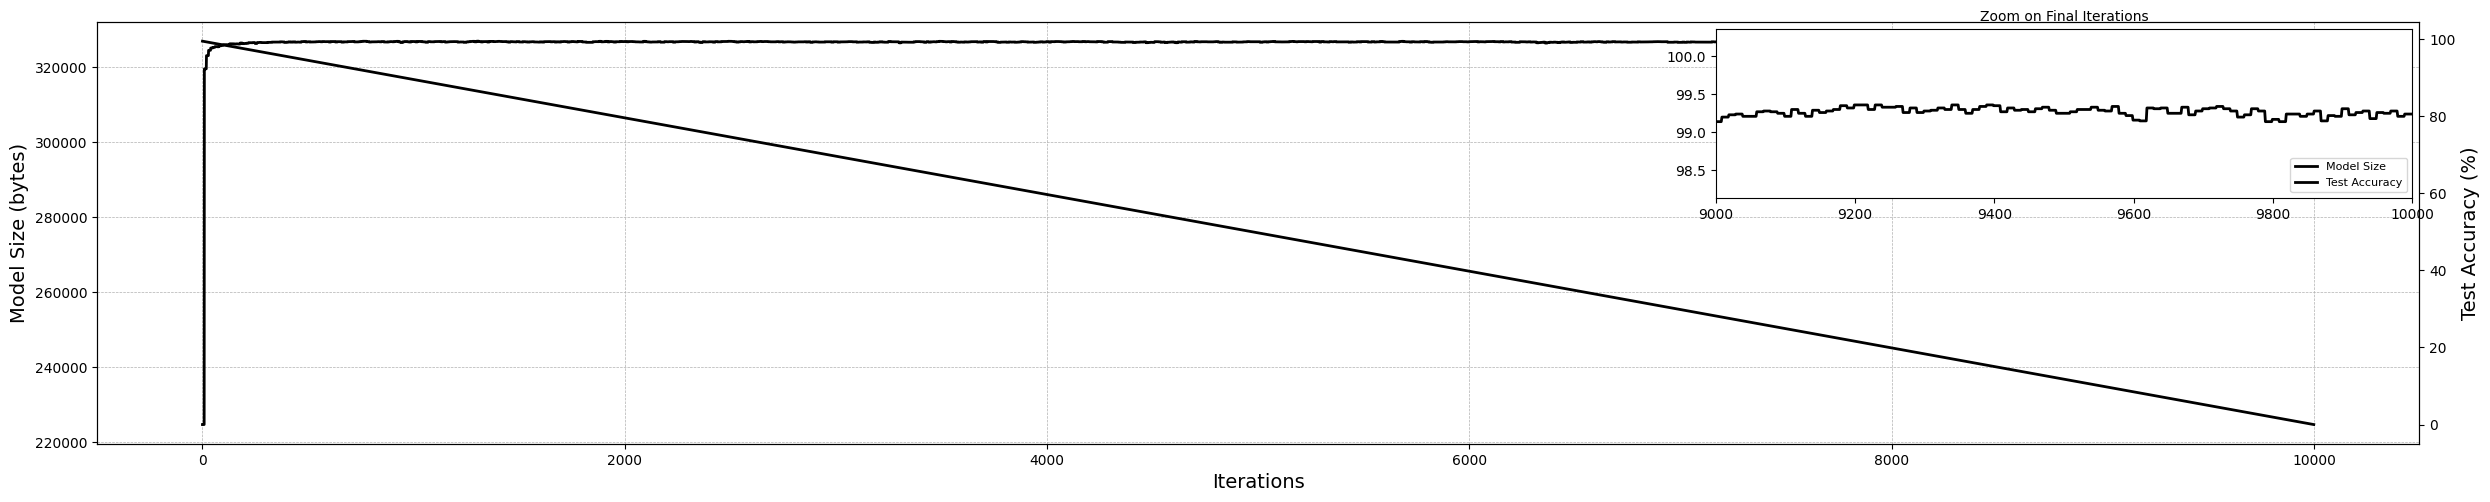

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

plt.figure(figsize=(25, 5))

# Create the main plot with two y-axes
ax1 = plt.gca()
ax2 = ax1.twinx()

# Plot Model Size Decrease in black
ax1.plot(range(len(bytes_used)), bytes_used, color='black', linewidth=2, label='Model Size (bytes)')
ax1.set_xlabel('Iterations', fontsize=14, color='black')
ax1.set_ylabel('Model Size (bytes)', fontsize=14, color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Plot Test Accuracy Increase in black
ax2.plot(range(len(test_accs)), test_accs, color='black', linewidth=2, label='Test Accuracy (%)')
ax2.set_ylabel('Test Accuracy (%)', fontsize=14, color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Title and Grid
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a zoomed inset for the last iterations
axins = inset_axes(ax1, width="30%", height="40%", loc="upper right")  # Adjust location and size

# Zoom in on the final iterations (e.g., last 10% of iterations)
zoom_start = int(len(bytes_used) * 0.9)  # Change 0.9 to zoom more/less
axins.plot(range(zoom_start, len(bytes_used)), bytes_used[zoom_start:], color='black', linewidth=2)
axins.plot(range(zoom_start, len(test_accs)), test_accs[zoom_start:], color='black', linewidth=2)

# Customize the inset appearance
axins.set_xlim(zoom_start, len(bytes_used))
axins.set_ylim(min(test_accs[zoom_start:]) - 1, max(test_accs[zoom_start:]) + 1)  # Adjust limits for better view
axins.set_title("Zoom on Final Iterations", fontsize=10)

# Add a legend to the inset
axins.legend(['Model Size', 'Test Accuracy'], loc='lower right', fontsize=8)

# Combine Legends from both axes
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()

# Adjust layout for better spacing
plt.tight_layout()

# Save and Show the Plot
# plt.savefig('size_vs_accuracy_zoomed_black.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()


In [14]:
# Save the model 
torch.save(model.state_dict(), 'modelquantizedfinal.pth') 

In [15]:
# Print final metrics
print(f"Final Test Accuracy: {test_acc:.2f}%")
print(f"Final Safety Accuracy: {safety_acc:.2f}%")
print(f"Initial Safety Accuracy: {initial_safety_acc:.2f}%")
print(f"Final Model Size: {model_bytes:.2f} bytes")
print(f"Total Training Loss: {loss:.4f}")
print(f"Total Q Bits: {Q:.4f}")

Final Test Accuracy: 99.24%
Final Safety Accuracy: 91.70%
Initial Safety Accuracy: 6.40%
Final Model Size: 224730.32 bytes
Total Training Loss: 2.0591
Total Q Bits: 20.4649
